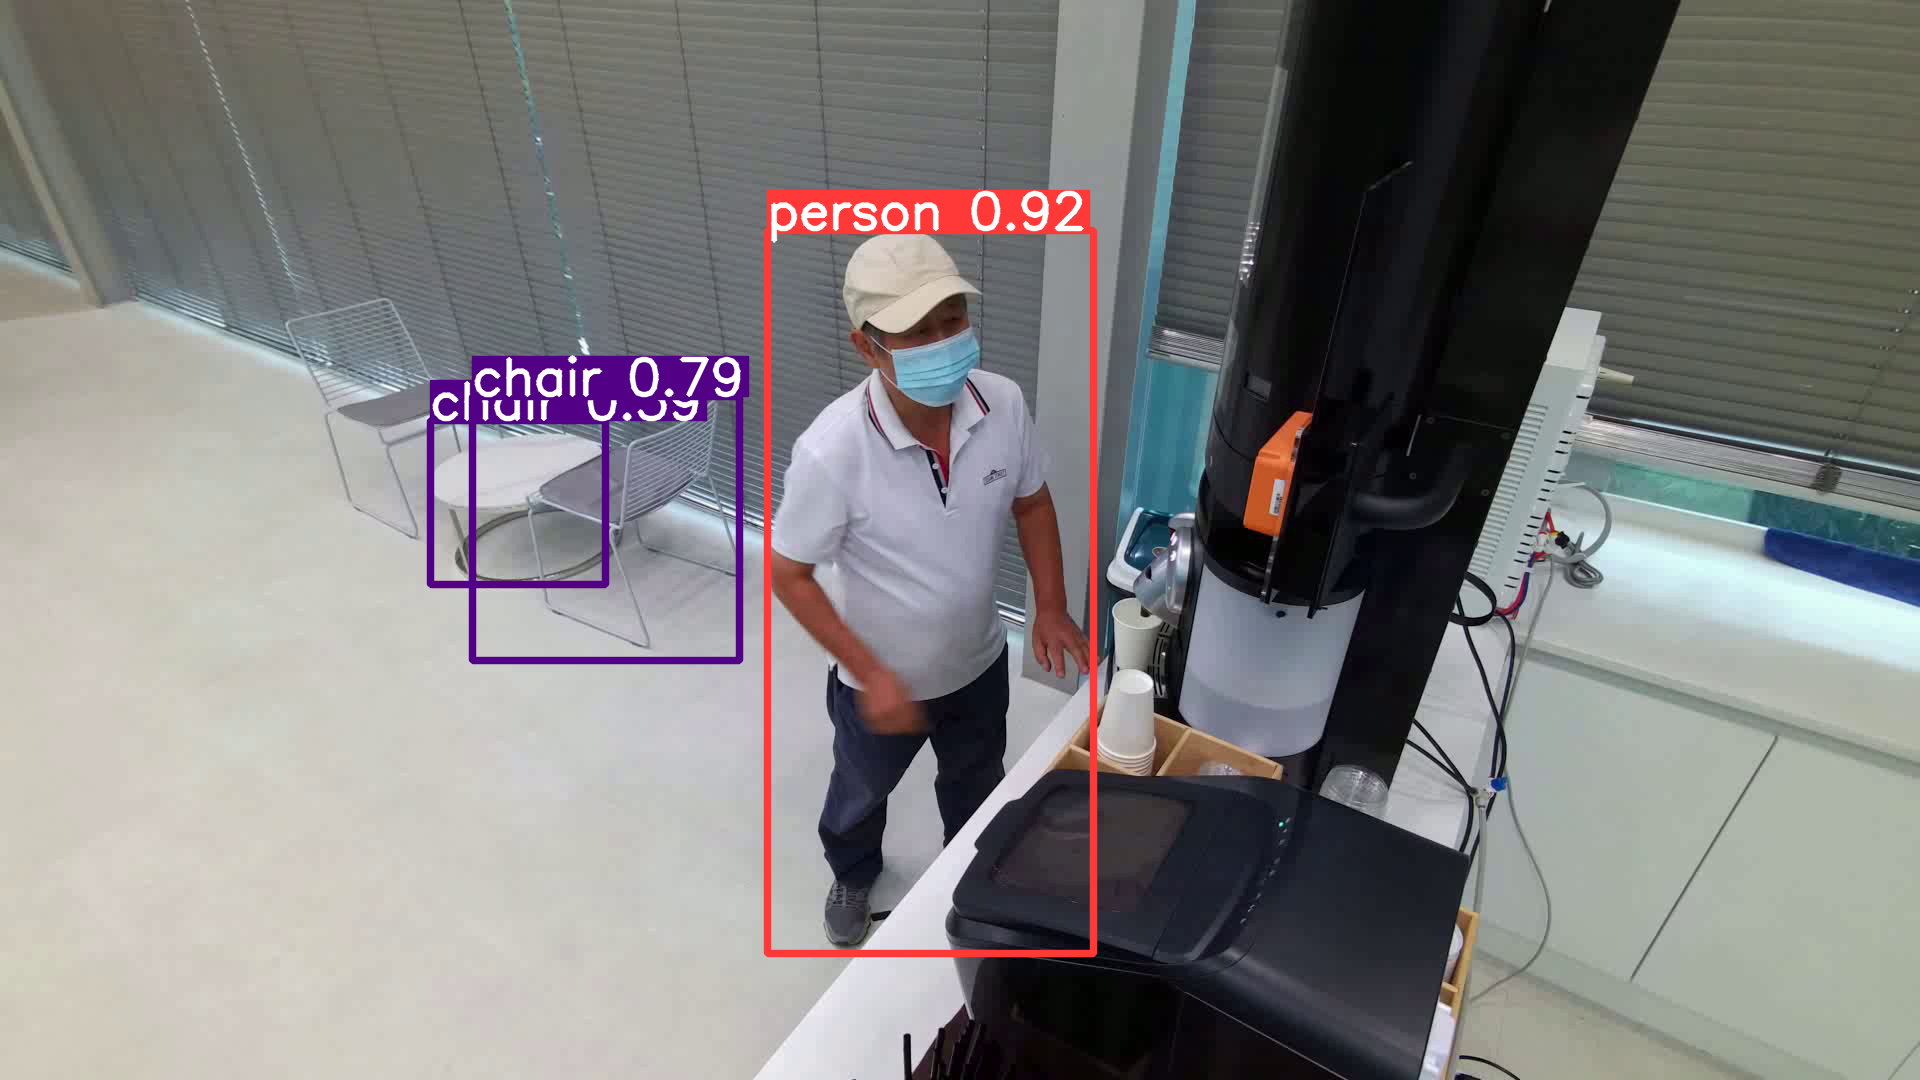

In [3]:
import torch
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

# 이미지 파일 경로
image_path = 'C:/Users/user/Downloads/output/test2/normal/normal_1.jpg'

# YOLOv5 모델 로드
#model = torch.hub.load('ultralytics/yolov5:v5.0', 'yolov5s')

# 이미지에서 사람 감지
results = model(image_path)

# 사람의 bounding box 좌표 출력
for detection in results.xyxy[0].cpu().numpy():
    class_id, confidence, x_min, y_min, x_max, y_max = detection
    if int(class_id) == 0:  # 클래스가 0인 경우는 사람
        print(f"Person detected with confidence: {confidence:.2f}")
        print(f"BBox coordinates: ({x_min:.2f}, {y_min:.2f}, {x_max:.2f}, {y_max:.2f})")

# 결과 시각화
results.show()
plt.show()


In [7]:
# 미디어 파이프로 사람만 뽑아내기
import cv2
import mediapipe as mp
from pathlib import Path

# 미디어 파이프의 Holistic 모듈 초기화
mp_holistic = mp.solutions.holistic
holistic = mp_holistic.Holistic()

# 이미지가 저장된 폴더 경로
input_folder = "C:/Users/user/Downloads/output/test2/test.11"

# 사용자가 지정한 출력 폴더 경로
output_folder_path = "C:/Users/user/Downloads/output/test2/normal_person"
output_folder = Path(output_folder_path)
output_folder.mkdir(exist_ok=True)

# 폴더 내 모든 이미지 파일에 대해 처리
for image_path in Path(input_folder).glob("*.jpg"):
    # 이미지 로딩
    img = cv2.imread(str(image_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # 미디어 파이프를 사용하여 사람 감지
    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        results = holistic.process(img_rgb)

        # 결과에서 사람 영역 추출
        if results.pose_landmarks is not None:
            landmarks = results.pose_landmarks.landmark
            x = int(min(landmarks[mp_holistic.PoseLandmark.LEFT_SHOULDER].x, landmarks[mp_holistic.PoseLandmark.RIGHT_SHOULDER].x) * img.shape[1])
            y = int(min(landmarks[mp_holistic.PoseLandmark.LEFT_SHOULDER].y, landmarks[mp_holistic.PoseLandmark.RIGHT_SHOULDER].y) * img.shape[0])
            w = int(abs(landmarks[mp_holistic.PoseLandmark.LEFT_SHOULDER].x - landmarks[mp_holistic.PoseLandmark.RIGHT_SHOULDER].x) * img.shape[1])
            h = int(abs(landmarks[mp_holistic.PoseLandmark.LEFT_SHOULDER].y - landmarks[mp_holistic.PoseLandmark.RIGHT_SHOULDER].y) * img.shape[0])
            
            person_image = img[y:y+h, x:x+w]

            # 저장할 경로 설정 (파일명 앞에 'person_'을 붙임)
            output_path = output_folder / f"person_{image_path.name}"
            cv2.imwrite(str(output_path), person_image)


In [31]:
#동영상 프레임으로 저장
import cv2
import os

# 동영상 파일이 들어있는 폴더 경로
video_folder = "C:/Users/user/Downloads/DATA-20231222T061633Z-001/DATA/Normal"

# 이미지를 저장할 폴더 경로
output_folder = "C:/Users/user/Downloads/DATA-20231222T061633Z-001/DATA/Normal_frame"
os.makedirs(output_folder, exist_ok=True)

# 폴더 내의 동영상 파일들에 대해 반복
for filename in os.listdir(video_folder):
    video_path = os.path.join(video_folder, filename)
    
    # 동영상 파일인지 확인
    if filename.endswith((".mp4", ".avi", ".mkv", ".mov")):
        # 동영상 로딩
        cap = cv2.VideoCapture(video_path)

        # 프레임 수 확인
        fps = cap.get(cv2.CAP_PROP_FPS)
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        # 각 프레임을 이미지로 저장
        for frame_number in range(frame_count):
            # 프레임 읽기
            ret, frame = cap.read()
            
            if not ret:
                break

            # 이미지 저장
            output_path = os.path.join(output_folder, f"{filename}_{frame_number:04d}.jpg")
            cv2.imwrite(output_path, frame)

        # 동영상 객체 해제
        cap.release()

print(f"Frames extracted and saved to {output_folder}")


Frames extracted and saved to C:/Users/user/Downloads/DATA-20231222T061633Z-001/DATA/Normal_frame


In [35]:
#경로 내에 있는 이미지에 대해 키포인트 jpg,txt 추출
import os
import torch
from torchvision.models.detection import keypointrcnn_resnet50_fpn
from torchvision.transforms import functional as F
from PIL import Image, ImageDraw
import numpy as np

# 모델 로딩
model = keypointrcnn_resnet50_fpn(pretrained=True)
model.eval()

# 이미지 폴더 경로
image_folder = "C:/Users/user/Downloads/DATA-20231222T061633Z-001/DATA/Abnormal_frame"

# 결과를 저장할 폴더 경로
output_folder = "C:/Users/user/Downloads/DATA-20231222T061633Z-001/DATA/Abnormal_keypoint"
os.makedirs(output_folder, exist_ok=True)

# 이미지 폴더 내의 모든 이미지에 대해 반복
for filename in os.listdir(image_folder):
    if filename.endswith((".png", ".jpg", ".jpeg")):
        image_path = os.path.join(image_folder, filename)

        # 이미지 로딩
        img = Image.open(image_path).convert("RGB")

        # 이미지를 텐서로 변환
        img_tensor = F.to_tensor(img)
        img_tensor = img_tensor.unsqueeze(0)

        # 추론
        with torch.no_grad():
            prediction = model(img_tensor)

        # 키포인트 추출 결과
        keypoints = prediction[0]['keypoints'][0].numpy()

        # 결과 시각화 및 저장
        draw = ImageDraw.Draw(img)
        for kp in keypoints:
            x, y, conf = kp
            if conf > 0.5:
                draw.ellipse([x - 5, y - 5, x + 5, y + 5], fill="red")

        # 시각화된 이미지를 저장
        output_path = os.path.join(output_folder, f"keypoints_{filename}")
        img.save(output_path)

        # 키포인트 정보를 numpy 배열로 저장
        keypoints_np = np.array(keypoints)
        np.savetxt(output_path.replace(".jpg", ".txt").replace(".png", ".txt"), keypoints_np, fmt="%f", delimiter=",")


In [ ]:
#jpg, txt 파일들 분류 코드
import os
import shutil

# 원본 폴더와 분류할 폴더들의 경로
source_folder = "C:/Users/user/Downloads/DATA-20231222T061633Z-001/DATA/Abnormal_keypoint"
image_destination_folder = "C:/Users/user/Downloads/DATA-20231222T061633Z-001/DATA/Abnormal_jpg"
keypoint_destination_folder = "C:/Users/user/Downloads/DATA-20231222T061633Z-001/DATA/Abnormal_txt"

# 분류할 폴더들이 없다면 생성
os.makedirs(image_destination_folder, exist_ok=True)
os.makedirs(keypoint_destination_folder, exist_ok=True)

# 원본 폴더 내의 모든 파일에 대해 반복
for filename in os.listdir(source_folder):
    file_path = os.path.join(source_folder, filename)

    # 파일이 이미지인지 확인
    if filename.lower().endswith(".jpg"):
        destination_folder = image_destination_folder
    elif filename.lower().endswith(".txt"):
        destination_folder = keypoint_destination_folder
    else:
        # 이미지 또는 키포인트 파일이 아닌 경우 다음 파일로 건너뜀
        continue

    # 파일을 목적지 폴더로 이동
    destination_path = os.path.join(destination_folder, filename)
    shutil.move(file_path, destination_path)

print("파일 분류 완료")


In [39]:
#키포인트를 이용해 주변 이미지 패치 추출
import cv2
import numpy as np
import os

def extract_keypoint_patches(image, keypoints, patch_size=32):
    patches = []
    for keypoint in keypoints:
        x, y = int(keypoint[0]), int(keypoint[1])
        patch = image[y - patch_size//2 : y + patch_size//2, x - patch_size//2 : x + patch_size//2]
        patches.append(patch)
    return patches

# 이미지와 KeyPoint를 추출할 폴더 경로
image_folder = "C:/Users/user/Downloads/DATA-20231222T061633Z-001/DATA/Abnormal_jpg"
keypoints_folder = "C:/Users/user/Downloads/DATA-20231222T061633Z-001/DATA/Abnormal_txt"

# 이미지 폴더 내의 모든 이미지 파일에 대해 반복
for image_filename in os.listdir(image_folder):
    # 이미지 파일 경로
    image_path = os.path.join(image_folder, image_filename)

    # 이미지 로딩
    image = cv2.imread(image_path)

    # KeyPoint 파일 경로
    keypoint_filename = os.path.splitext(image_filename)[0] + ".txt"
    keypoint_path = os.path.join(keypoints_folder, keypoint_filename)

    # KeyPoint 정보 로딩
    if os.path.exists(keypoint_path):
        keypoints = np.loadtxt(keypoint_path, delimiter=',')
        
        # 이미지 패치 추출
        patches = extract_keypoint_patches(image, keypoints)

        # 추출된 패치를 저장하거나 다른 용도로 사용할 수 있음
        for i, patch in enumerate(patches):
            output_folder = "C:/Users/user/Downloads/DATA-20231222T061633Z-001/DATA/final_Abnormal"
            os.makedirs(output_folder, exist_ok=True)
            output_path = os.path.join(output_folder, f"{image_filename}_patch_{i}.jpg")
            cv2.imwrite(output_path, patch)


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

# 키포인트 데이터를 읽어오는 함수
def read_keypoint_data_from_txt(file_path):
    with open(file_path, 'r') as file:
        keypoint_data = [list(map(float, line.strip().split(','))) for line in file]
        return np.array(keypoint_data)

# 키포인트를 이미지로 변환하는 함수 (간단한 예시)
def keypoints_to_image(keypoints, image_size=(128, 128, 3)):
    image = np.zeros(image_size)
    for keypoint in keypoints:
        x, y, _ = keypoint
        x, y = int(x), int(y)
        if 0 <= x < image_size[1] and 0 <= y < image_size[0]:
            image[y, x, :] = 1.0  # 키포인트 위치에 특정 값을 할당 (간단한 예시로 1.0으로 설정)
    return image

# CNN 모델 정의
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# EarlyStopping 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 예제 데이터 폴더 경로와 레이블 설정
data_folder = "C:/Users/user/Downloads/DATA-20231222T061633Z-001/DATA/Abnormal_txt"
file_paths = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith('.txt')]
labels = [1] * len(file_paths)  # 이상행동에 해당하는 파일들은 레이블 1로 설정

# 데이터를 훈련 세트와 검증 세트로 나눔
train_file_paths, val_file_paths, train_labels, val_labels = train_test_split(file_paths, labels, test_size=0.2, random_state=42)

# 데이터 전처리 및 모델 학습
for file_path, label in zip(train_file_paths, train_labels):
    keypoints = read_keypoint_data_from_txt(file_path)
    image_data = keypoints_to_image(keypoints)
    image_data = np.expand_dims(image_data, axis=0)  # 배치 차원 추가
    model.fit(image_data, np.array([label]), epochs=15, callbacks=[early_stopping])

# 학습된 모델 저장
model.save("keypoint_cnn_model.h5")

# 검증 세트를 사용하여 모델 평가
val_accuracy = 0
for file_path, label in zip(val_file_paths, val_labels):
    keypoints = read_keypoint_data_from_txt(file_path)
    image_data = keypoints_to_image(keypoints)
    image_data = np.expand_dims(image_data, axis=0)  # 배치 차원 추가
    val_accuracy += model.evaluate(image_data, np.array([label]))[1]

val_accuracy /= len(val_file_paths)
print(f"Validation Accuracy: {val_accuracy}")

In [4]:
import os
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 데이터 로드 함수 수정
def load_data(folder_path):
    data = []
    labels = []

    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"):
            file_path = os.path.join(folder_path, filename)

            # 파일에서 데이터 로드 및 파싱
            with open(file_path, 'r') as file:
                lines = file.readlines()
                frame_data = [list(map(float, line.strip().split(','))) for line in lines]

            # 이상행동으로 레이블을 설정 (모두 이상행동으로 설정)
            label = 1

            data.append(frame_data)
            labels.append(label)

    return np.array(data), np.array(labels)

# LSTM 모델 정의
def create_model(input_shape):
    model = Sequential()
    model.add(LSTM(128, input_shape=input_shape))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification이므로 출력 레이어의 노드는 1개, 활성화 함수는 'sigmoid'
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# 데이터 폴더 경로 설정
data_folder = "C:/Users/user/Downloads/DATA-20231222T061633Z-001/DATA/Abnormal_txt"

# 데이터 로드
X, y = load_data(data_folder)

# 데이터 전처리 (필요에 따라 추가 전처리 수행)

# 모델 학습을 위한 입력 형태 설정
input_shape = X.shape[1:]

# 모델 생성
model = create_model(input_shape)

# 모델 학습
model.fit(X, y, epochs=10, batch_size=32, validation_split=0.2)



Epoch 1/10
49/49 [==============================] - 3s 23ms/step - loss: 0.0800 - accuracy: 1.0000 - val_loss: 0.0116 - val_accuracy: 1.0000
Epoch 2/10
49/49 [==============================] - 1s 10ms/step - loss: 0.0070 - accuracy: 1.0000 - val_loss: 0.0046 - val_accuracy: 1.0000
Epoch 3/10
49/49 [==============================] - 1s 10ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.0027 - val_accuracy: 1.0000
Epoch 4/10
49/49 [==============================] - 1s 10ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 5/10
49/49 [==============================] - 1s 11ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 6/10
49/49 [==============================] - 1s 11ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 7/10
49/49 [==============================] - 1s 11ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 9.9561e-04 - val_accuracy: 1.0000
Epoch 8/1

In [ ]:
import os
import cv2
import numpy as np

def extract_keypoint_patches(image, keypoints, patch_size=32):
    patches = []
    half_patch_size = patch_size // 2

    for keypoint in keypoints:
        x, y = int(keypoint[0]), int(keypoint[1])

        # 이미지 경계 안에 있는지 확인
        if half_patch_size <= x < image.shape[1] - half_patch_size and half_patch_size <= y < image.shape[0] - half_patch_size:
            patch = image[y - half_patch_size:y + half_patch_size, x - half_patch_size:x + half_patch_size]
            patches.append(patch)

    return patches

def save_keypoint_images(image_folder, keypoint_folder, output_folder):
    image_files = [file for file in os.listdir(image_folder) if file.endswith('.jpg')]
    
    for image_file in image_files:
        image_path = os.path.join(image_folder, image_file)
        keypoint_file = os.path.join(keypoint_folder, image_file.replace('.jpg', '_keypoints.txt'))

        # 이미지 로딩
        image = cv2.imread(image_path)

        # 키포인트 로딩
        if os.path.exists(keypoint_file):
            keypoints = np.loadtxt(keypoint_file, delimiter=',')
            
            # 이미지에서 관절 주변 패치 추출
            patches = extract_keypoint_patches(image, keypoints)

            # 이미지 저장 폴더 생성
            output_subfolder = os.path.join(output_folder, image_file.replace('.jpg', ''))
            os.makedirs(output_subfolder, exist_ok=True)

            # 추출된 패치를 저장
            for i, patch in enumerate(patches):
                patch_path = os.path.join(output_subfolder, f'patch_{i}.jpg')
                cv2.imwrite(patch_path, patch)

if __name__ == "__main__":
    image_folder = "C:/Users/user/Downloads/DATA-20231222T061633Z-001/DATA/Abnormal_jpg"
    keypoint_folder = "C:/Users/user/Downloads/DATA-20231222T061633Z-001/DATA/Abnormal_txt"
    output_folder = "C:/Users/user/Downloads/DATA-20231222T061633Z-001/DATA/final_Abnormal"

    save_keypoint_images(image_folder, keypoint_folder, output_folder)


In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import mediapipe as mp

# 미디어 파이프 초기화
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()

# 학습된 모델 불러오기
model_path = "C:/Users/user/Downloads/keypoint_cnn_model.h1"
model = tf.keras.models.load_model(model_path)

# 동영상 파일 경로
video_path = "C:/Users/user/Downloads/output/theif_video/output_thief_0.mp4"

# 동영상 열기
cap = cv2.VideoCapture(video_path)

while cap.isOpened():
    ret, frame = cap.read()

    if not ret:
        break

    # 미디어 파이프를 사용하여 키포인트 추출
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = pose.process(frame_rgb)

# 추출된 키포인트 데이터
    if results.pose_landmarks:
        landmarks = np.array([(lm.x, lm.y, lm.z) for lm in results.pose_landmarks.landmark]).flatten()

    # 키포인트를 이용하여 모델에 입력 데이터 생성
    # 여기에서는 간단한 예시로 키포인트를 이미지로 변환하여 사용
        image_data = keypoints_to_image(landmarks)
        image_data = np.expand_dims(image_data, axis=0)  # 배치 차원 추가

        # 학습된 모델을 사용하여 이상 행동 감지
        prediction = model.predict(image_data)

        # 이상 행동일 경우 경고 표시
        if prediction[0] > 0.5:  # 이진 분류일 경우 0.5를 기준으로 설정
            cv2.putText(frame, "Abnormal Behavior Detected", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
            cv2.imshow("Abnormal Detection", frame)
            cv2.waitKey(0)  # 키 입력을 기다림 (아무 키나 누를 때까지 대기)

    # 동영상 화면 출력
    cv2.imshow("Video", frame)

    # 'q' 키를 누르면 종료
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
